In [19]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#chargement fichiers
df = pd.read_csv("./data/rating.csv", sep="\t",encoding="utf-8-sig", error_bad_lines=False, low_memory=False)


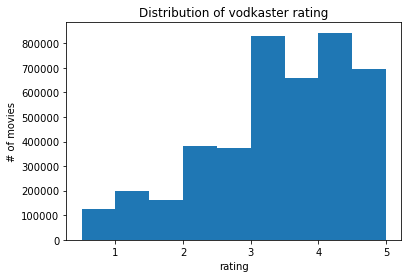

In [2]:
# Distrib des avg_ratings (1-5)
plt.hist(df.value,bins=[0.5,1,1.5,2,2.5,3,3.5,4,4.5,5])
plt.xlabel("rating")
plt.ylabel("# of movies")
plt.title("Distribution of vodkaster rating")

#On affiche
plt.show()

In [27]:
#Jointure avec les films vodkaster
dff = pd.read_csv("./data/vod_films.csv", sep="\t",encoding="utf-8", error_bad_lines=False, low_memory=False)
dff = dff.loc[:,{'id','title','year'}]
dff = dff.rename(columns = {'id':'object_id'})
dff = dff.merge(df,how='inner',on='object_id')
dff = dff.loc[:,{'object_id','title','year','user_id','value','creation_date'}]
dff = dff.rename(columns = {'object_id':'film_id'})
dff[:5]
df=dff
#on est obligé de construire une clé titre+année pour distinguer d'éventuels doublons de titres
df["title_year"]=df["title"]+"_"+df["year"]
df[:5]

b'Skipping line 22345: expected 28 fields, saw 29\n'


,year,value,film_id,title,creation_date,user_id,title_year
0,2007,1.0,1269,Le Chaos,2010-05-05 16:50:29,67781,Le Chaos_2007
1,2007,3.5,1269,Le Chaos,2012-02-22 01:35:52,756947,Le Chaos_2007
2,2007,2.0,1269,Le Chaos,2013-04-22 16:24:22,907563,Le Chaos_2007
3,2007,4.0,1269,Le Chaos,2016-02-14 03:01:12,929770,Le Chaos_2007
4,2004,4.0,1275,Alexandrie... New York,2012-03-20 16:02:14,737070,Alexandrie... New York_2004


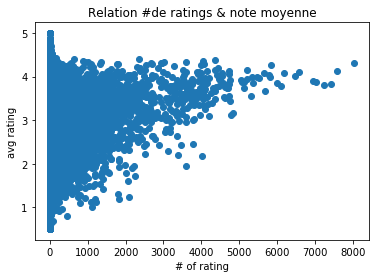

In [4]:
#"popularité" des films (nb de notes+note moyenne)
dfp = df.groupby("title_year")["value"].agg(['mean','count']).reset_index().sort_values(ascending=False, by ='count')

plt.xlabel("# of rating")
plt.ylabel("avg rating")
plt.title("Relation #de ratings & note moyenne")
plt.scatter(dfp["count"],dfp["mean"])

#On affiche
plt.show()

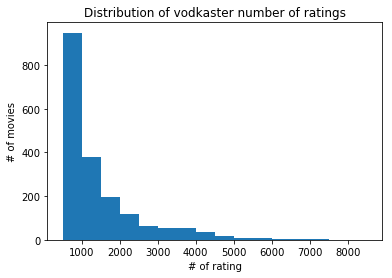

In [5]:
# Distrib du nb de rating (=popularité des films)
rg = df.groupby('film_id').count()['user_id']
plt.hist(rg,bins=range(500,9000,500))
plt.xlabel("# of rating")
plt.ylabel("# of movies")
plt.title("Distribution of vodkaster number of ratings")

#On affiche
plt.show()

In [6]:
#Combien d'utilisateurs distincts ?
len(df.user_id.unique())

25857

In [7]:
#Creation du dataset des films moins bien notés par les utilisateurs ayant vu ce titre 
titres = ["Bon à rien","Le Sang séché","La Fin d'une douce nuit",
          "La Source thermale d'Akitsu", "18 Jeunes gens à l'appel de l'orage",
          "Evasion du Japon", "Histoire écrite sur l'eau",
          "Le Lac des femmes","Passion ardente",
          "Flamme et femme", "Amours dans la neige",
          "Adieu clarté d'été","Eros + Massacre",
          "Purgatoire Eroica","Aveux, théories, actrices",
          "Coup d'Etat", "Promesse", "Onimaru","Femmes en miroir"]

#création d'un datasetpour stocker des observations meta : nb d'utilisateurs, notes moyennes
meta = pd.DataFrame()
meta["titre"]=titres
meta["nb_noteurs"]=0
meta["nb_films_moyens_vus_par_noteur"]=0
meta["note_moyenne"]=0
meta["ecart_type"]=0
meta["ecart_moyen_other_movies"]=0
meta["année"]=0    


In [8]:
for i in range(len(titres)):

    titre = titres[i]
    #Récupération des utilisateurs et leurs notes sur le film {titre}
    dft = df[df["title"]==titre]
    if len(dft)>0:
        #Récupération des autres films vus par les utilisateurs ayant noté le film {titre} et différentiel de notes
        df_other = pd.DataFrame()
        df_other = dft.loc[:,{'value','user_id'}]
        df_other = df_other.rename(columns = {'value':'titre_ref_score'})
        df_other = df_other.merge(dff,how='inner',on='user_id')
        df_other = df_other.rename(columns = {'value':'titre_other_score'})
        df_other['score_ref_moins_other'] = df_other.titre_ref_score-df_other.titre_other_score

        #calcul de la note moyenne, variance & nb de notes sur le film {titre}
        meta.loc[meta[meta["titre"]==titre].index,"note_moyenne"] = float(round(dft.value.mean(),2))
        meta.loc[meta[meta["titre"]==titre].index,"nb_noteurs"] = dft.value.count()
        meta.loc[meta[meta["titre"]==titre].index,"ecart_type"] = float(round(dft.value.var(),2))
        meta.loc[meta[meta["titre"]==titre].index,"année"] = dft.year.unique()[0]
        meta.loc[meta[meta["titre"]==titre].index,"nb_films_moyens_vus_par_noteur"] = int(len(df_other)/dft.value.count())
        meta.loc[meta[meta["titre"]==titre].index,"ecart_moyen_other_movies"] = float(round(df_other.score_ref_moins_other.mean(),2))

In [10]:
meta.sort_values(by="nb_noteurs", ascending=False)

,titre,nb_noteurs,nb_films_moyens_vus_par_noteur,note_moyenne,ecart_type,ecart_moyen_other_movies,année
12,Eros + Massacre,19,2927,4.16,0.75,0.94,1969
3,La Source thermale d'Akitsu,16,1839,4.16,0.89,1.04,1962
7,Le Lac des femmes,10,2715,3.65,0.28,0.63,1966
18,Femmes en miroir,9,2325,4.00,0.69,0.71,2001
6,Histoire écrite sur l'eau,8,2482,4.12,0.62,1.22,1965
15,Coup d'Etat,7,3278,3.36,0.81,0.49,1973
0,Bon à rien,7,2494,3.43,0.37,0.47,1960
13,Purgatoire Eroica,6,2118,3.50,0.90,0.19,1970
2,La Fin d'une douce nuit,6,1175,3.08,1.14,-0.28,1961
8,Passion ardente,5,1971,3.30,0.45,-0.04,1967


In [32]:
#Récupérons les utilisateurs ayant vu le plus de films de yoshida
user_most_movies = meta.rename(columns = {'titre':'title'}).merge(df,how='inner',on='title')
user_most_movies=user_most_movies.loc[:,{'title','user_id','value','creation_date'}]
user_most_movies.groupby('user_id').count()['value'].sort_values(ascending=False)[:15]

user_id
740153     19
561605     15
183088     10
769652      9
314654      8
175301      6
708416      6
683476      5
727386      5
675584      4
298259      3
686207      2
740059      2
1372061     2
756947      2
Name: value, dtype: int64

In [53]:
user_most_movies.creation_date=pd.to_datetime(user_most_movies['creation_date'])
single_user = user_most_movies[user_most_movies.user_id==756947]
single_user[:100]

,value,creation_date,title,user_id
45,4.0,2011-12-26 13:55:05,Histoire écrite sur l'eau,756947
83,4.0,2011-12-29 01:15:57,Eros + Massacre,756947


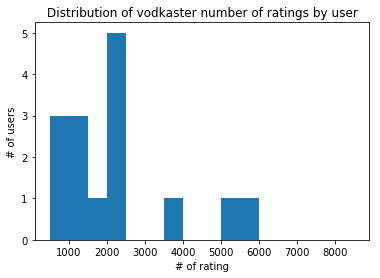

In [11]:
#Zoomons sur eros + massacre (un film très apprécié) et le sang séché (un film peu apprécié)
dft = df[df["title"]=="Eros + Massacre"] #"Le Sang séché"]
if len(dft)>0:
    #Récupération des autres films vus par les utilisateurs ayant noté le film {titre} et différentiel de notes
    df_other = pd.DataFrame()
    df_other = dft.loc[:,{'value','user_id'}]
    df_other = df_other.rename(columns = {'value':'titre_ref_score'})
    df_other = df_other.merge(dff,how='inner',on='user_id')
    df_other = df_other.rename(columns = {'value':'titre_other_score'})
    df_other['score_ref_moins_other'] = df_other.titre_ref_score-df_other.titre_other_score
# Distrib du nb de note par utilisateur
rg = df_other.groupby('user_id').count()['year']
plt.hist(rg,bins=range(500,9000,500))
plt.xlabel("# of rating")
plt.ylabel("# of users")
plt.title("Distribution of vodkaster number of ratings by user")

#On affiche
plt.show()

#COnclusion : pour le titre de "eros + massacre", le film a été vu par des gros power users (3k films par user en moyenne oO)

In [12]:
#quels sont les autres films qui ont été les plus vus par ceux qui ont vu 'eros + massacre' ?
df_other.groupby('title').count()['user_id'].sort_values(ascending=False)[:10]
#en toute logique on a les films les plus populaires qui apparaissent....il faudrait virer les films 'trop vus'
#ceux qui apparaissent plus de fois que le nb de users correspondent à des films qui ont le même titre
#pour eliminer le pb il suffit de grouper par identifiant unique

title
Scarface                 30
Les Misérables           29
King Kong                29
Dracula                  25
Macbeth                  23
La Belle et la Bête      22
Solaris                  22
Les Visiteurs            21
La Planète des singes    21
Robin des Bois           21
Name: user_id, dtype: int64

In [13]:
df_other[:10]

,titre_ref_score,user_id,year,titre_other_score,film_id,title,title_year,score_ref_moins_other
0,5.0,183088,1995,3.0,1461,Les Anges déchus,Les Anges déchus_1995,2.0
1,5.0,183088,2008,1.0,1529,Les Cendres du temps - Redux,Les Cendres du temps - Redux_2008,4.0
2,5.0,183088,2004,4.0,1541,2046,2046_2004,1.0
3,5.0,183088,2000,5.0,1553,In the Mood for Love,In the Mood for Love_2000,0.0
4,5.0,183088,1997,4.0,1557,Happy Together,Happy Together_1997,1.0
5,5.0,183088,1996,1.0,1559,Les Cendres du temps,Les Cendres du temps_1996,4.0
6,5.0,183088,1991,3.0,1565,Nos années sauvages,Nos années sauvages_1991,2.0
7,5.0,183088,1995,4.0,1571,Chungking Express,Chungking Express_1995,1.0
8,5.0,183088,2004,5.0,1883,Three times,Three times_2004,0.0
9,5.0,183088,2004,3.0,1893,Café lumière,Café lumière_2004,2.0


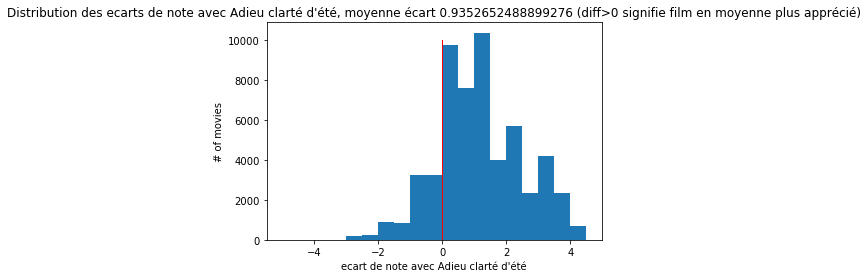

In [14]:
#Comment les users ont t'ils apprécié ce film par rapport au reste de leur collection ?
plt.hist(df_other.score_ref_moins_other,bins=np.arange(-5,5,0.5))
plt.xlabel("ecart de note avec "+titre)
plt.ylabel("# of movies")
plt.title("Distribution des ecarts de note avec {}, moyenne écart {} (diff>0 signifie film en moyenne plus apprécié)".format(titre, df_other.score_ref_moins_other.mean()))
plt.plot([0,0], [0,10000], color='red', linestyle='-', linewidth=1)

#On affiche
plt.show()

#Pour Eros+M, le film est en moyenne aprécié 1 cran au dessus des autres films vus par les users l'ayant noté

In [15]:
#Quels sont films les plus proches et les plus lointains en terme de note
dft = df_other.groupby('title')['score_ref_moins_other'].agg(['mean','count']).reset_index().sort_values(ascending=False, by ='mean')
#n'affichons que ceux qui ont été vus au moins par 5 users
dft[dft['count']>5]
#intepretation : c'est interessant parce que ça commence à "polariser" les gouts, très clairement 
#les films les plus lointains négativement sont des boues et les plus lointains positivements
#sont des films "artsy" et vus uniquement par un public de connaisseurs
#et si on enlève le filtre d'un film vu par aux moins 5 users, on voit plus spécifiquement pointer des films vus par des
#connaisseurs en cinéma japonais

,title,mean,count
1096,Banlieue 13 ultimatum,3.833333,6
14755,Taxi 4,3.785714,7
5030,Iznogoud,3.666667,6
14754,Taxi 3,3.625000,8
16384,Vercingétorix : la légende du druide roi,3.583333,6
10551,"Les Rivières pourpres 2, les anges de l'Apocal...",3.583333,6
842,Astérix aux jeux olympiques,3.562500,8
1095,Banlieue 13,3.555556,9
3090,Double zéro,3.500000,7
6503,La Beuze,3.500000,6


Idées
- faire un scatterplot pour chaque film entre nb de voteur et note moyenne en écart
- créer N subplots pour toute la liste des films de yoshida pour avoir une meilleure idée du positionnement dans un cursus de cinéphile
- tracer un "criticogramme" e.g quand temporellement un mec a noté les yoshida dans son "cursus" de cinéphile => besoin de la date de la notation.
- question : comment sélectionner les films "aux antipodes" ? comment gérer la popularité ?
- idée à venir : moteur de recommandation (filtrage collaboratif)

Sinon 
- difficulté de jointure imdb
- feedback D3.js
- feedback neo4j

A faire
- apparition des ratings de yoshida/oshima dans le temps, par film
- apparition des ratings de yoshida/oshima dans le temps, par utilisateur pour ceux qui vu plus que N films
    vs niveau d'activité de l'utilisateur
- regression / prédiction
- montrer les films qui ont des pics de notation (trolls)
- évolution des notes au fil du cursus cinéphile
- montrage les utilisateurs les plus actifs
- évolution fréquence personnages gays au fil des années